In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Install necessary packages
!pip install shap

# Import necessary libraries
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
from collections import defaultdict
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import shap
import librosa.display
from skimage.io import imread
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.tree import export_text
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.svm import SVC
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier


# Load metadata
metadata_path = '/content/drive/MyDrive/Bird sound classification data/bird_songs_metadata.csv'
zip_path = '/content/drive/MyDrive/Bird sound classification data/archive (1).zip'
metadata = pd.read_csv(metadata_path)
metadata.head()

# Extract features from audio files
def extract_features(file_path, zip_ref):
    with zip_ref.open(file_path) as file:
        y, sr = librosa.load(file, sr=None)
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        S_DB = librosa.power_to_db(S, ref=np.max)
        return np.mean(S_DB, axis=1)  # Using mean as a simple feature

# Prepare dataset
features = []
labels = []

with zipfile.ZipFile(zip_path, 'r') as z:
    for index, row in metadata.iterrows():
        file_path = os.path.join('wavfiles', row['filename'])
        if file_path in z.namelist():
            features.append(extract_features(file_path, z))
            labels.append(row['species'])

features = np.array(features)
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(features, labels_encoded, test_size=0.2, random_state=42)
# Get the original indices of the test set
_, X_test_indices, _, y_test_indices = train_test_split(np.arange(len(labels_encoded)), labels_encoded, test_size=0.2, random_state=42)


# Log Mel and MFCC combined
def extract_mfcc_features(file_path, zip_ref):
    with zip_ref.open(file_path) as file:
        y, sr = librosa.load(file, sr=None)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        return np.mean(mfcc, axis=1)

# Prepare MFCC features
mfcc_features = []
labels_mfcc = []

with zipfile.ZipFile(zip_path, 'r') as z:
    for index, row in metadata.iterrows():
        file_path = os.path.join('wavfiles', row['filename'])
        if file_path in z.namelist():
            mfcc_features.append(extract_mfcc_features(file_path, z))
            labels_mfcc.append(row['species'])

mfcc_features = np.array(mfcc_features)
label_encoder_mfcc = LabelEncoder()
labels_encoded_mfcc = label_encoder_mfcc.fit_transform(labels_mfcc)

# Split the dataset for MFCC features
X_train_mfcc, X_test_mfcc, y_train_mfcc, y_test_mfcc = train_test_split(mfcc_features, labels_encoded_mfcc, test_size=0.2, random_state=42)

# Combined features
combined_features = np.hstack((features, mfcc_features))
labels_combined = labels_encoded  # Assuming the same labels

# Split the dataset for combined features
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(combined_features, labels_combined, test_size=0.2, random_state=42)

# Classes
classes = label_encoder.classes_


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
def train_rf_model(X_train, y_train):
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    return clf

def plot_confusion_matrix(y_true, y_pred, classes, title):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

def plot_feature_importance(importances, title):
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(importances)), importances)
    plt.xlabel('Feature Index')
    plt.ylabel('Importance')
    plt.title(title)
    plt.show()

def cumulative_feature_importance(importances, title):
    sorted_indices = np.argsort(importances)[::-1]
    cumulative_importances = np.cumsum(importances[sorted_indices])
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(cumulative_importances)), cumulative_importances)
    plt.xlabel('Number of Features')
    plt.ylabel('Cumulative Importance')
    plt.title(title)
    plt.show()

def plot_roc_curve(y_test, y_score, classes, title):
    y_test_bin = label_binarize(y_test, classes=classes)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    plt.figure(figsize=(10, 8))
    for i in range(len(classes)):
        plt.plot(fpr[i], tpr[i], label=f'Class {classes[i]} (area = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

def classification_report_rf(X_train, y_train, X_test, y_test):
    clf = train_rf_model(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    return clf, y_pred

def plot_mel_spectrogram(file_path, zip_ref, title):
    with zip_ref.open(file_path) as file:
        y, sr = librosa.load(file, sr=None)
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        S_DB = librosa.power_to_db(S, ref=np.max)
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(S_DB, sr=sr, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title(title)
        plt.show()


In [3]:
def bar_graph_species(metadata):
    plt.figure(figsize=(10, 6))
    sns.countplot(data=metadata, x='species')
    plt.title('Distribution of Species')
    plt.xticks(rotation=45)
    plt.show()


In [4]:
def metadata_info(metadata):
    return metadata.info()


In [5]:
def mel_spectrogram_all_species(metadata, zip_path):
    species_count = defaultdict(int)
    max_plots_per_species = 5
    with zipfile.ZipFile(zip_path, 'r') as z:
        for index, row in metadata.iterrows():
            species = row['species']
            if species_count[species] < max_plots_per_species:
                file_path = os.path.join('wavfiles', row['filename'])
                if file_path in z.namelist():
                    with z.open(file_path) as file:
                        y, sr = librosa.load(file, sr=None)
                        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
                        S_DB = librosa.power_to_db(S, ref=np.max)
                        plt.figure(figsize=(10, 4))
                        librosa.display.specshow(S_DB, sr=sr, x_axis='time', y_axis='mel')
                        plt.colorbar(format='%+2.0f dB')
                        plt.title(f'Spectrogram for {species} ({file_path})')
                        plt.show()
                        species_count[species] += 1


In [6]:
def log_mel_rf_analysis(X_train, y_train, X_test, y_test, classes):
    clf, y_pred = classification_report_rf(X_train, y_train, X_test, y_test)
    plot_confusion_matrix(y_test, y_pred, classes, 'Confusion Matrix for Log Mel')
    plot_feature_importance(clf.feature_importances_, 'Feature Importances for Log Mel')
    cumulative_feature_importance(clf.feature_importances_, 'Cumulative Feature Importances for Log Mel')
    y_score = clf.predict_proba(X_test)
    plot_roc_curve(y_test, y_score, classes, 'ROC Curve for Log Mel (Random Forest)')


In [7]:
def mfcc_rf_analysis(X_train, y_train, X_test, y_test, classes):
    clf, y_pred = classification_report_rf(X_train, y_train, X_test, y_test)
    plot_confusion_matrix(y_test, y_pred, classes, 'Confusion Matrix for MFCC')
    plot_feature_importance(clf.feature_importances_, 'Feature Importances for MFCC')
    cumulative_feature_importance(clf.feature_importances_, 'Cumulative Feature Importances for MFCC')
    y_score = clf.predict_proba(X_test)
    plot_roc_curve(y_test, y_score, classes, 'ROC Curve for MFCC (Random Forest)')


In [8]:
def combined_rf_analysis(X_train, y_train, X_test, y_test, classes):
    clf, y_pred = classification_report_rf(X_train, y_train, X_test, y_test)
    plot_confusion_matrix(y_test, y_pred, classes, 'Confusion Matrix for Combined Features (Log Mel + MFCC)')
    plot_feature_importance(clf.feature_importances_, 'Feature Importances for Combined Features (Log Mel + MFCC)')
    y_score = clf.predict_proba(X_test)
    plot_roc_curve(y_test, y_score, classes, 'ROC Curve for Combined Features (Log Mel + MFCC)')


In [9]:
def classification_report_combined_rf(X_train, y_train, X_test, y_test):
    clf = train_rf_model(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    cross_val_scores = cross_val_score(clf, X_train, y_train, cv=5)
    print("Cross-validation Scores:", cross_val_scores)
    print("Mean Cross-validation Score:", np.mean(cross_val_scores))
    return clf


In [10]:
def classification_report_knn_mel(X_train, y_train, X_test, y_test):
    knn_classifier = KNeighborsClassifier(n_neighbors=5)
    knn_classifier.fit(X_train, y_train)
    y_pred_knn = knn_classifier.predict(X_test)
    print("Classification Report:\n", classification_report(y_test, y_pred_knn))
    return knn_classifier


In [11]:
def high_low_confidence_spectrograms_knn(zip_path, metadata, X_test, knn_classifier):
    y_prob_knn = knn_classifier.predict_proba(X_test)
    confidence_scores = np.max(y_prob_knn, axis=1)
    high_confidence_indices = np.argsort(confidence_scores)[-2:]
    low_confidence_indices = np.argsort(confidence_scores)[:2]
    with zipfile.ZipFile(zip_path, 'r') as z:
        for idx in high_confidence_indices:
            original_index = X_test_indices[idx]
            file_name = metadata.iloc[original_index]['filename']
            file_path = os.path.join('wavfiles', file_name)
            plot_mel_spectrogram(file_path, z, f"High Confidence: Mel Spectrogram of {file_name}")
        for idx in low_confidence_indices:
            original_index = X_test_indices[idx]
            file_name = metadata.iloc[original_index]['filename']
            file_path = os.path.join('wavfiles', file_name)
            plot_mel_spectrogram(file_path, z, f"Low Confidence: Mel Spectrogram of {file_name}")


In [12]:
def confusion_matrix_classification_report_svm(X_train, y_train, X_test, y_test):
    svm_classifier = SVC(probability=True, random_state=42)
    svm_classifier.fit(X_train, y_train)
    y_pred_svm = svm_classifier.predict(X_test)
    plot_confusion_matrix(y_test, y_pred_svm, classes, 'Confusion Matrix (SVM)')
    print("Classification Report:\n", classification_report(y_test, y_pred_svm))


In [13]:
def shap_svm(X_train, X_test, y_train):
    svm_classifier = SVC(probability=True, random_state=42)
    svm_classifier.fit(X_train, y_train)
    explainer = shap.KernelExplainer(svm_classifier.predict, X_train)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test)


In [14]:
def confusion_matrices_xgboost(X_train_log_mel, y_train_log_mel, X_test_log_mel, y_test_log_mel,
                               X_train_mfcc, y_train_mfcc, X_test_mfcc, y_test_mfcc,
                               X_train_combined, y_train_combined, X_test_combined, y_test_combined):
    # Log Mel
    xgb_log_mel = xgb.XGBClassifier(random_state=42)
    xgb_log_mel.fit(X_train_log_mel, y_train_log_mel)
    y_pred_log_mel = xgb_log_mel.predict(X_test_log_mel)
    plot_confusion_matrix(y_test_log_mel, y_pred_log_mel, classes, 'Confusion Matrix - XGBoost (Log Mel)')

    # MFCC
    xgb_mfcc = xgb.XGBClassifier(random_state=42)
    xgb_mfcc.fit(X_train_mfcc, y_train_mfcc)
    y_pred_mfcc = xgb_mfcc.predict(X_test_mfcc)
    plot_confusion_matrix(y_test_mfcc, y_pred_mfcc, classes, 'Confusion Matrix - XGBoost (MFCC)')

    # Combined
    xgb_combined = xgb.XGBClassifier(random_state=42)
    xgb_combined.fit(X_train_combined, y_train_combined)
    y_pred_combined = xgb_combined.predict(X_test_combined)
    plot_confusion_matrix(y_test_combined, y_pred_combined, classes, 'Confusion Matrix - XGBoost (Combined)')


In [15]:
def classification_report_feature_importance_xgboost(X_train, y_train, X_test, y_test):
    xgb_model = XGBClassifier(random_state=42)
    param_dist = {
        'n_estimators': [50, 100, 150],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.6, 0.8, 1.0]
    }
    random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=10, cv=3, random_state=42)
    random_search.fit(X_train, y_train)
    best_xgb = random_search.best_estimator_
    best_xgb.fit(X_train, y_train)
    y_pred_xgb = best_xgb.predict(X_test)
    plot_confusion_matrix(y_test, y_pred_xgb, classes, 'Confusion Matrix - XGBoost')
    print(f"Classification Report:\n{classification_report(y_test, y_pred_xgb)}")
    plot_importance(best_xgb, importance_type='weight', max_num_features=10)
    plt.title('Feature Importance (weight plot)')
    plt.show()
    results = pd.DataFrame(random_search.cv_results_)
    params = results['params']
    params_df = pd.DataFrame(params.tolist())
    for column in params_df.columns:
        params_df[column] = params_df[column].astype(float)
    plt.figure(figsize=(15, 10))
    sns.pairplot(params_df)
    plt.suptitle('Pair Plot of Hyperparameters', y=1.02)
    plt.show()


In [16]:
def shap_xgboost(X_train, y_train, X_test):
    xg_model = XGBClassifier(random_state=42)
    xg_model.fit(X_train, y_train)
    explainer = shap.TreeExplainer(xg_model)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test)


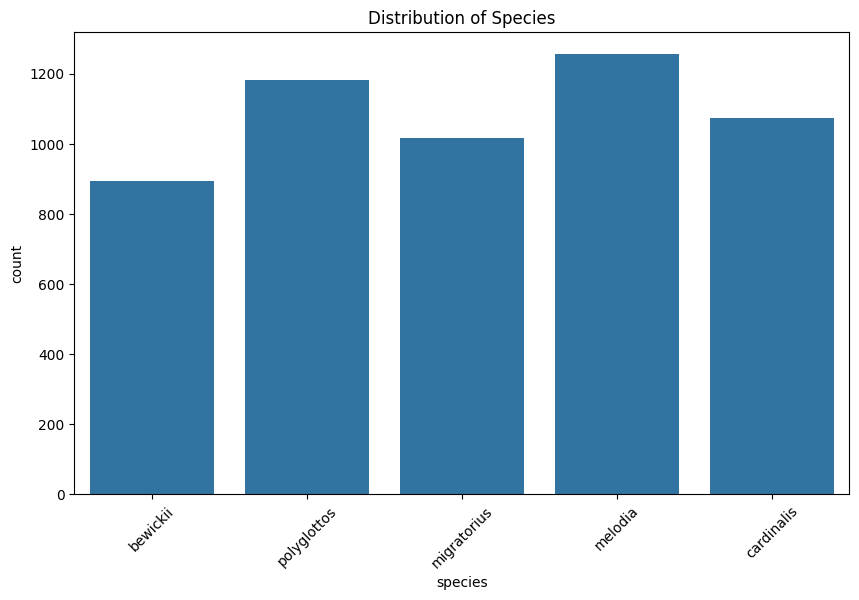

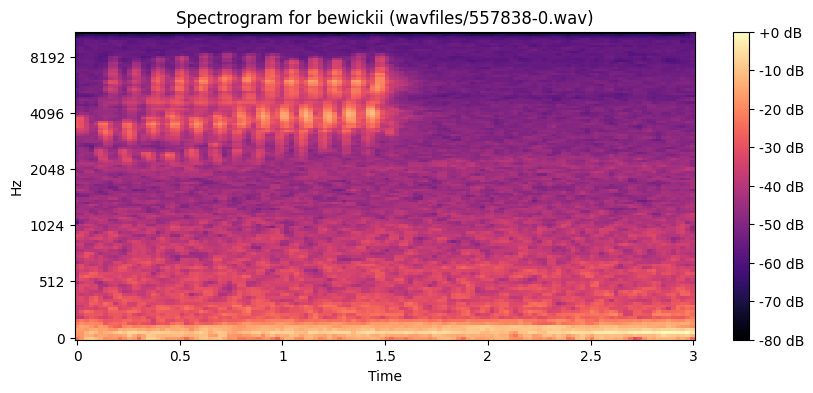

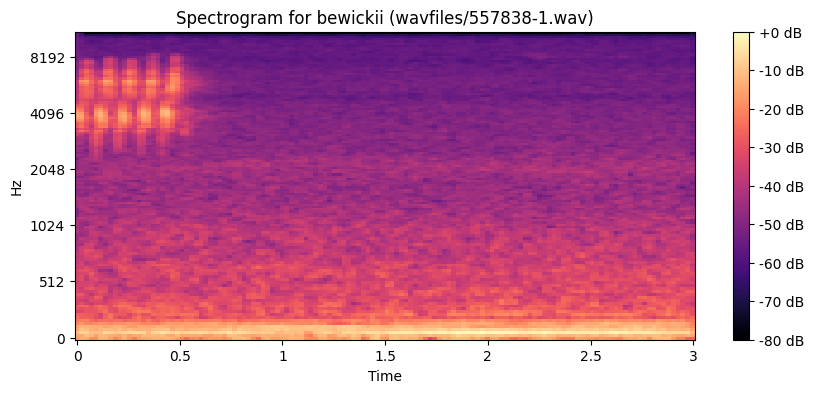

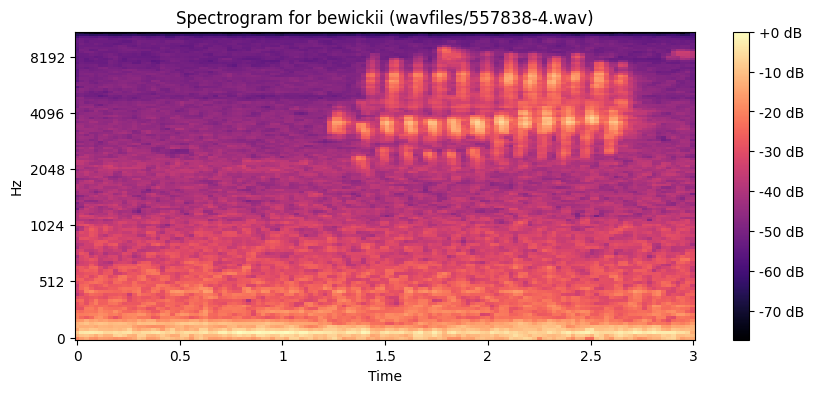

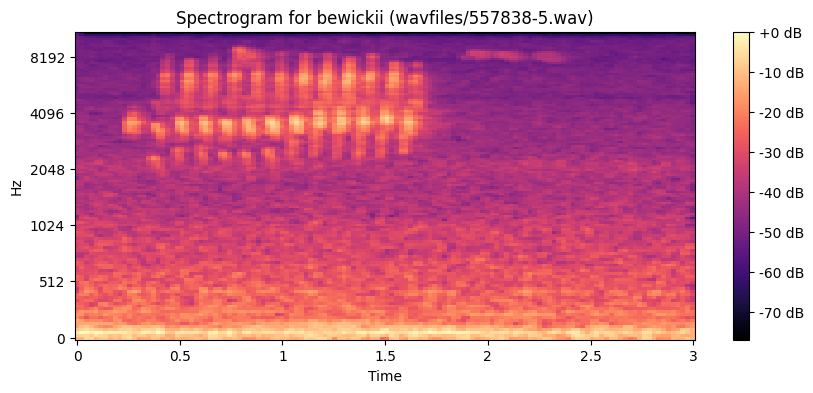

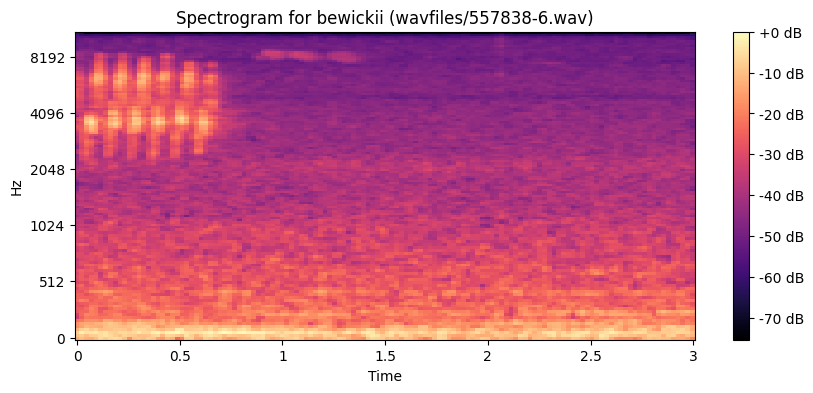

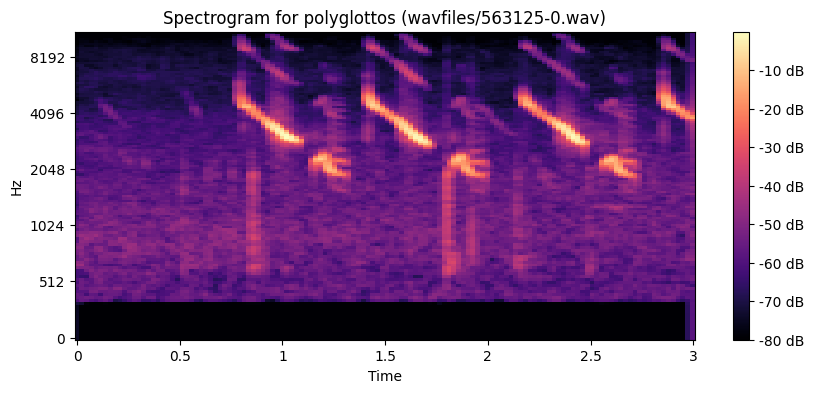

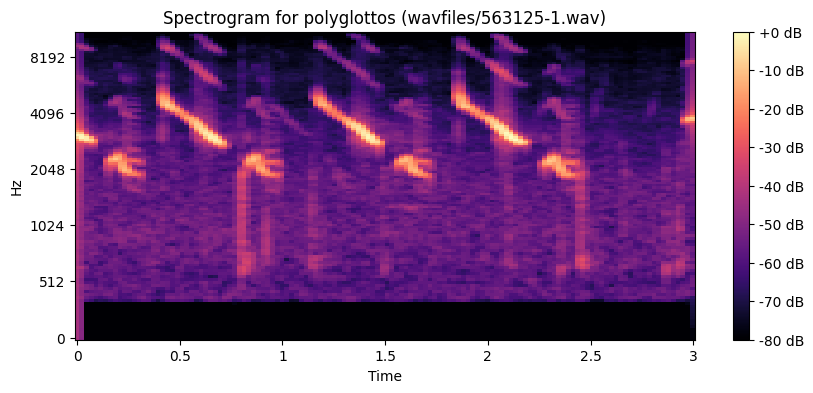

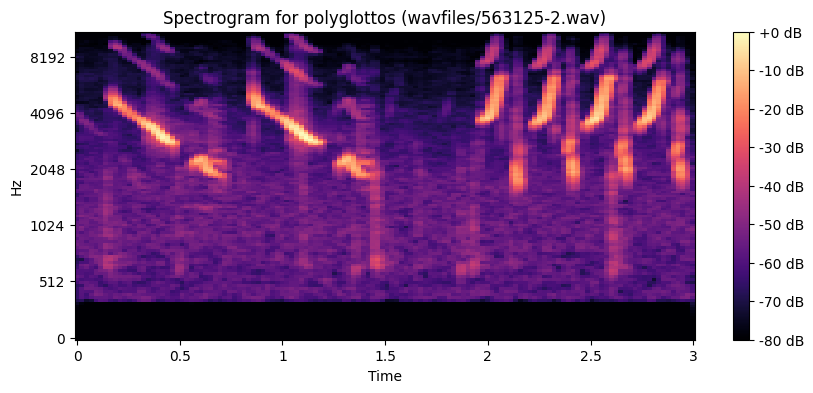

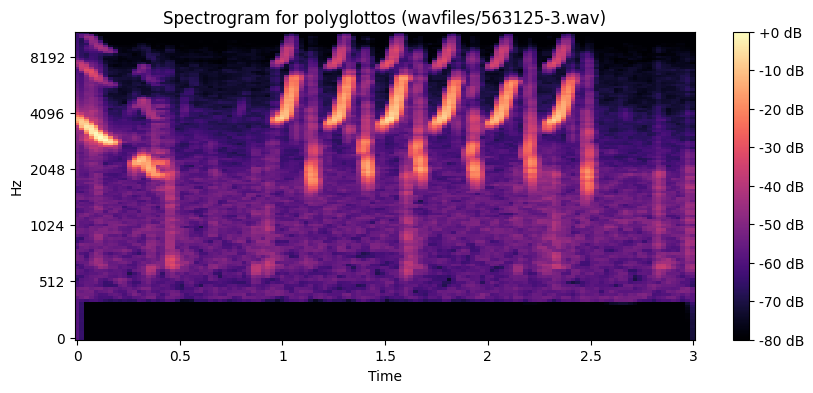

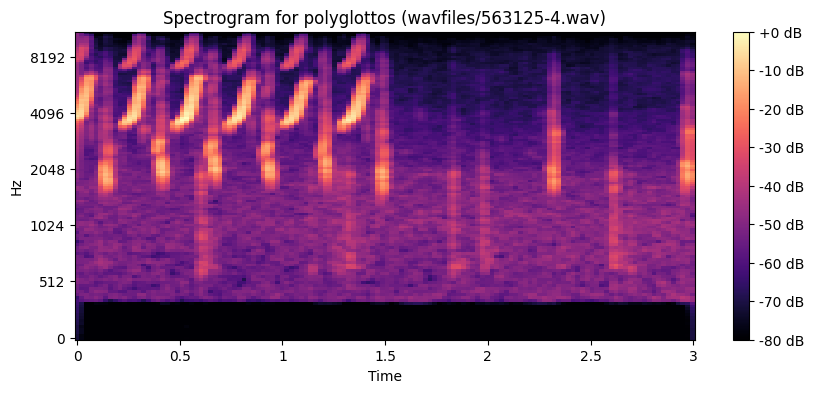

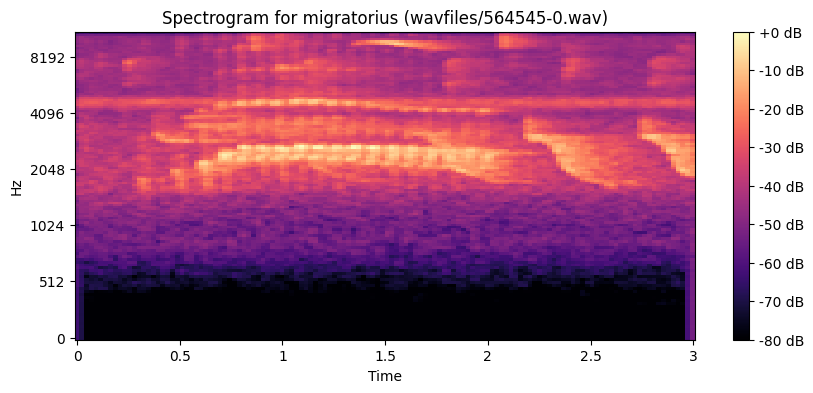

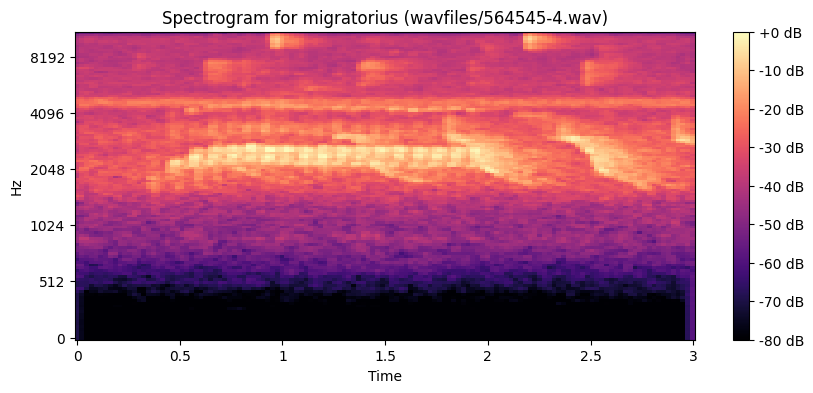

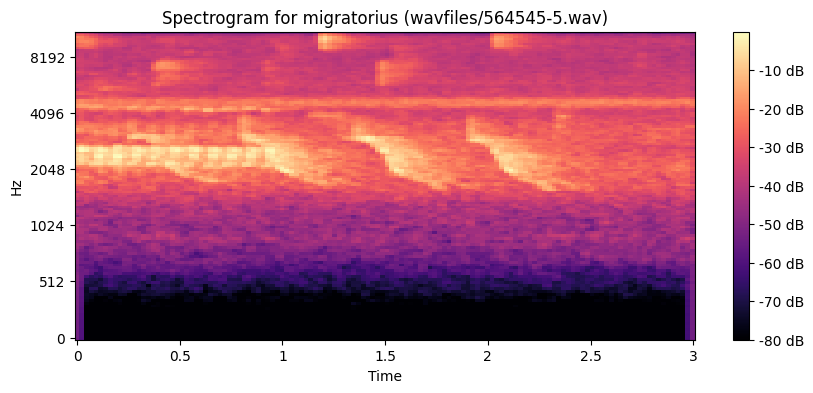

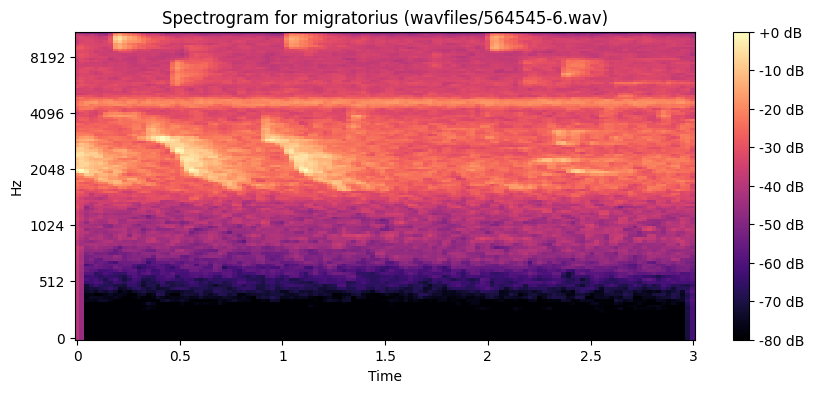

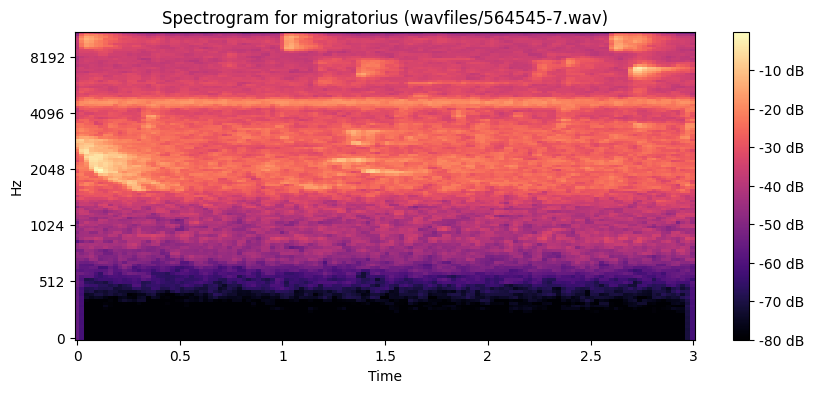

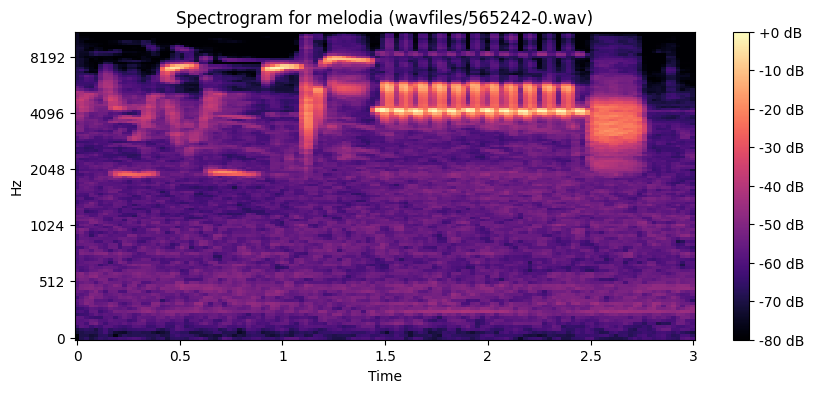

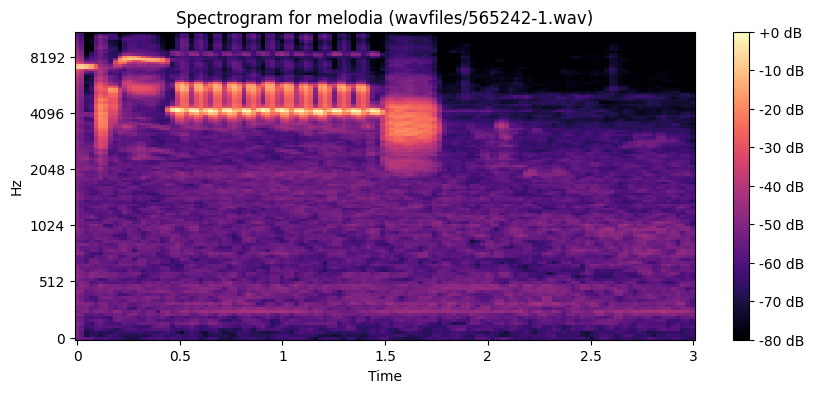

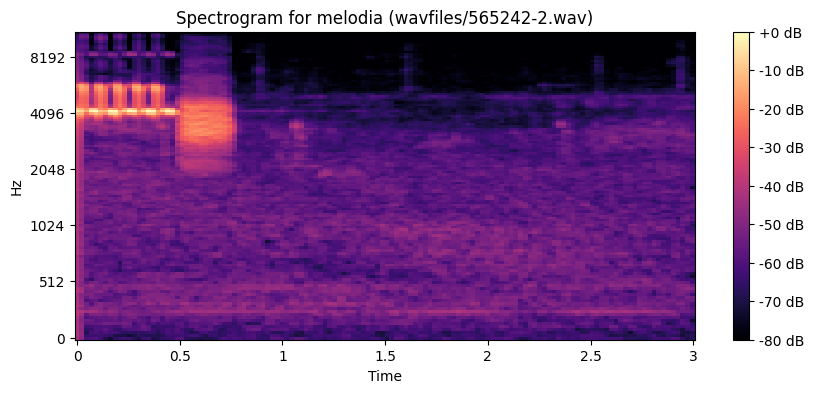

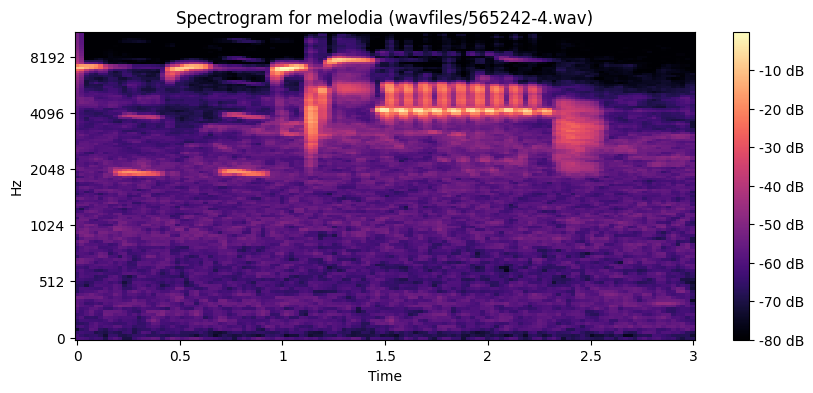

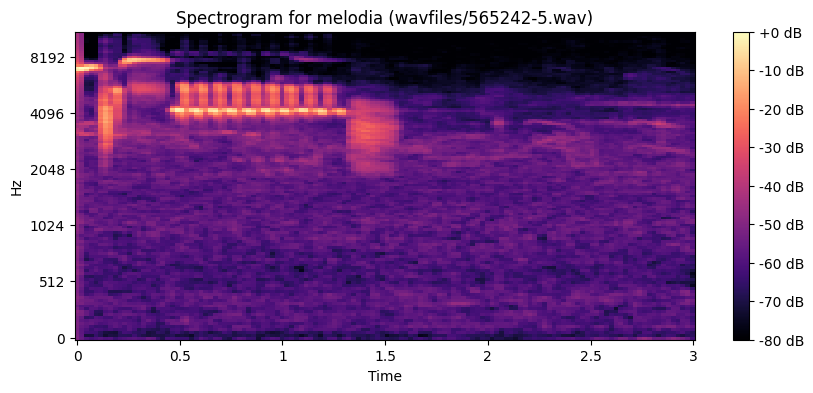

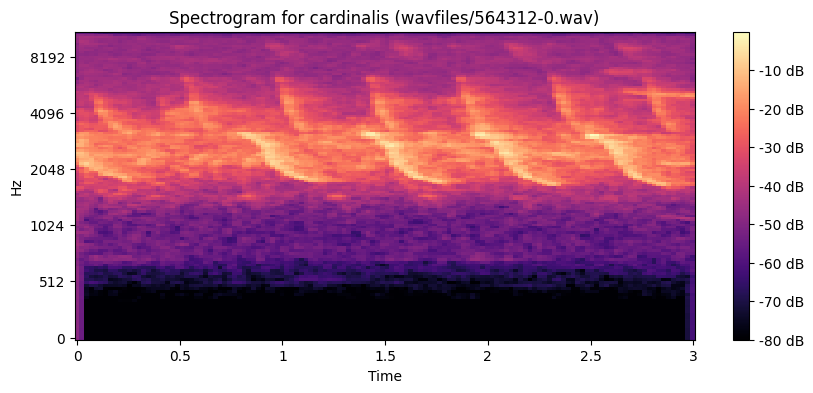

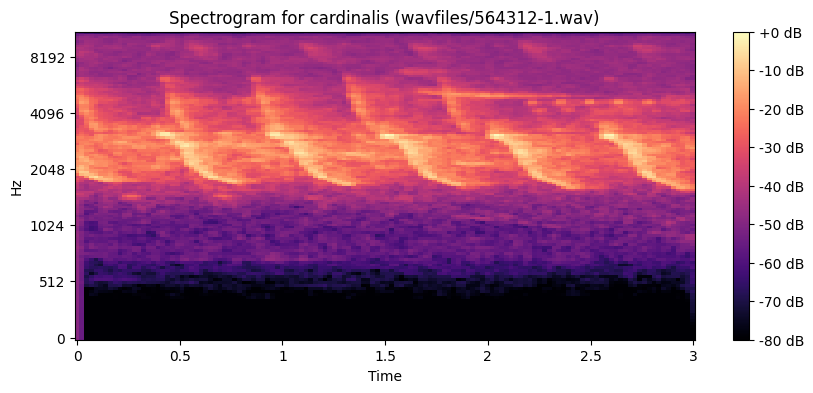

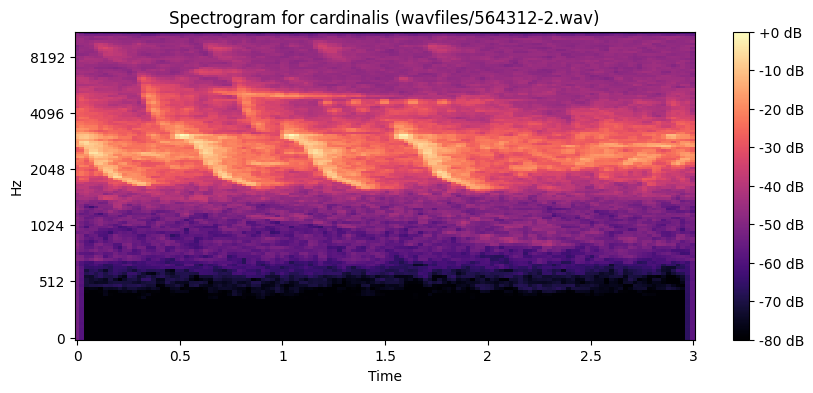

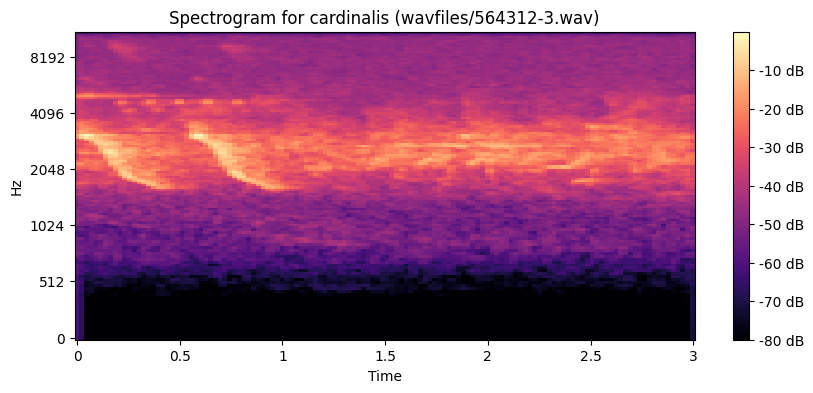

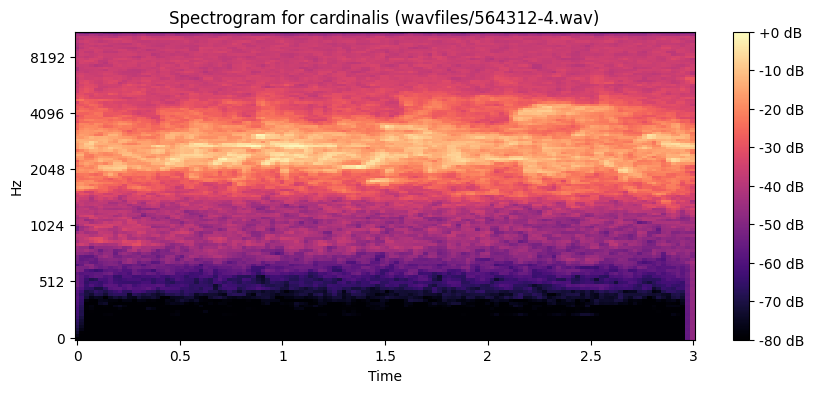

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.80      0.83       193
           1       0.82      0.81      0.82       204
           2       0.80      0.87      0.83       243
           3       0.86      0.91      0.89       207
           4       0.89      0.82      0.85       238

    accuracy                           0.84      1085
   macro avg       0.85      0.84      0.84      1085
weighted avg       0.85      0.84      0.84      1085



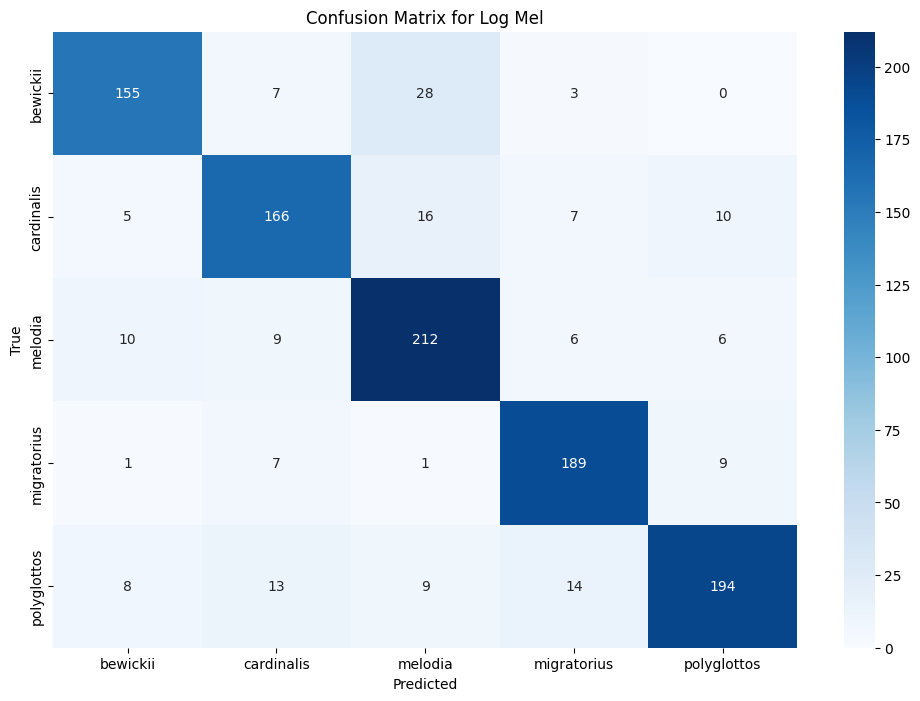

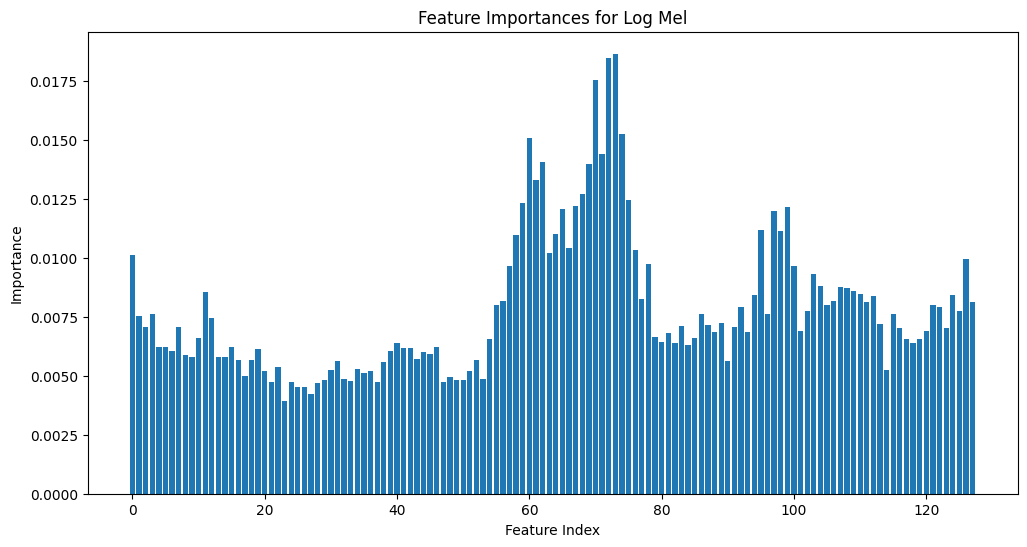

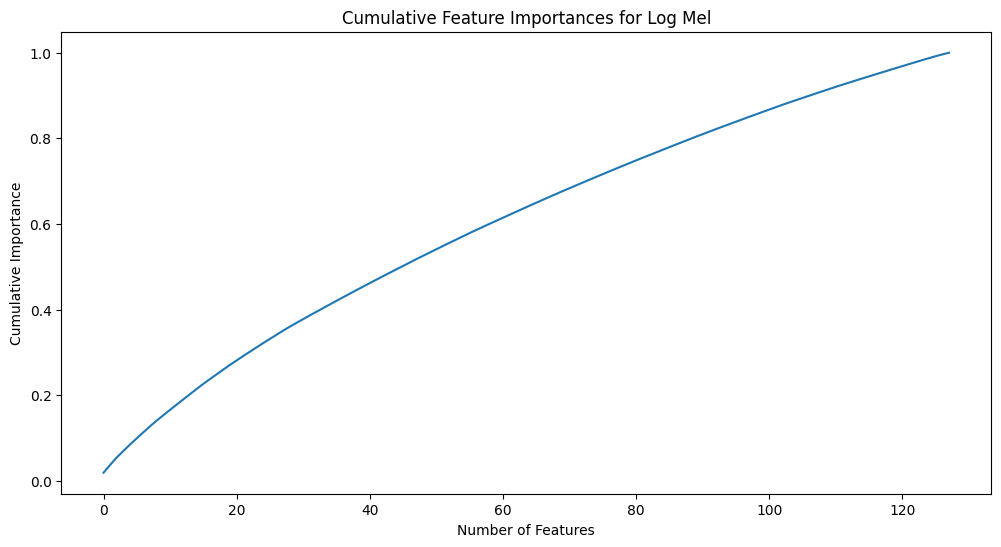

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


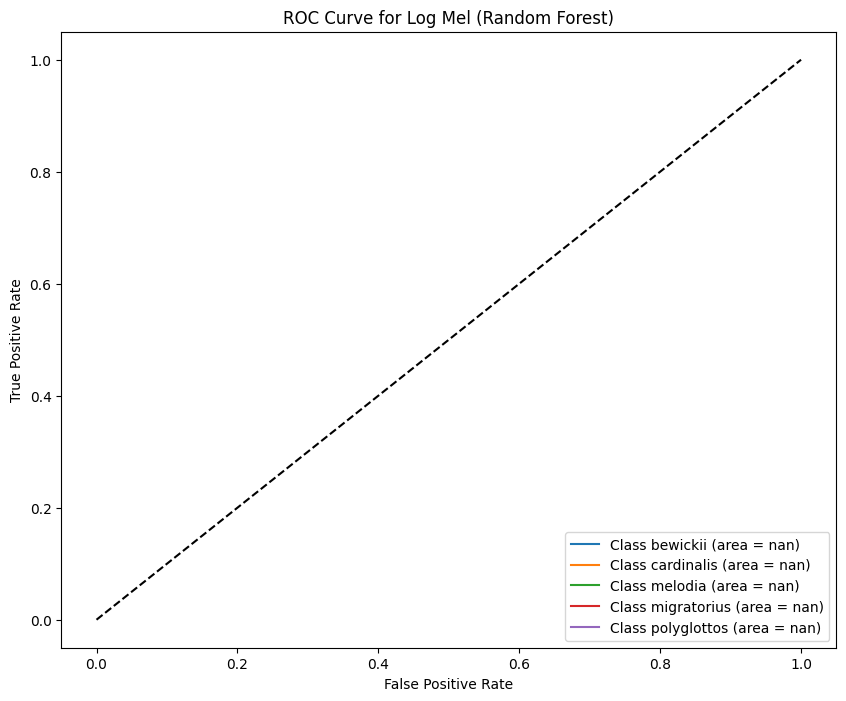

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.87      0.87       193
           1       0.91      0.91      0.91       204
           2       0.88      0.93      0.90       243
           3       0.89      0.96      0.92       207
           4       0.94      0.84      0.88       238

    accuracy                           0.90      1085
   macro avg       0.90      0.90      0.90      1085
weighted avg       0.90      0.90      0.90      1085



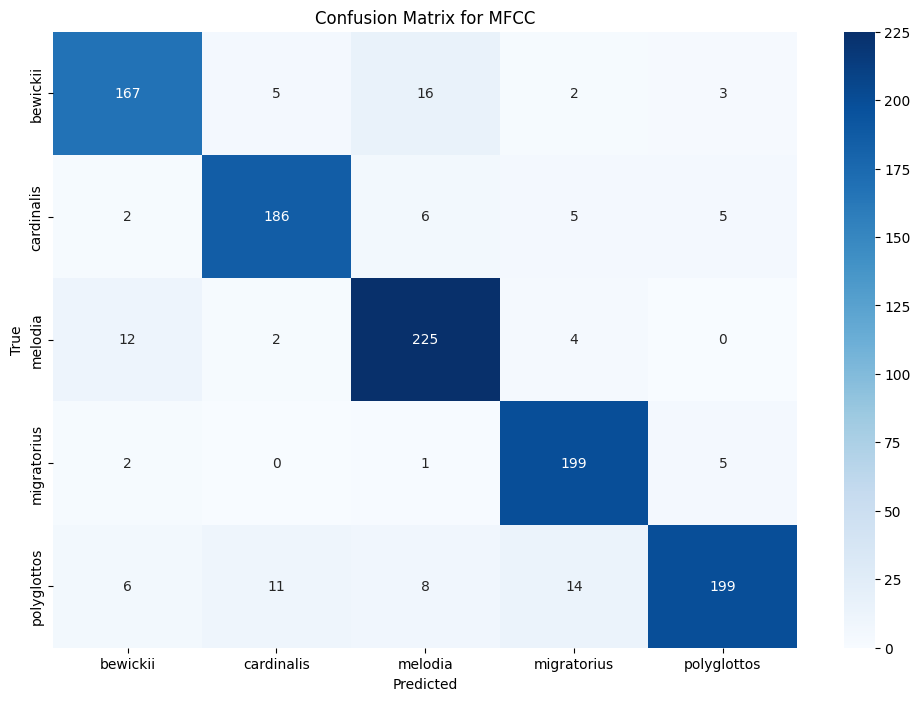

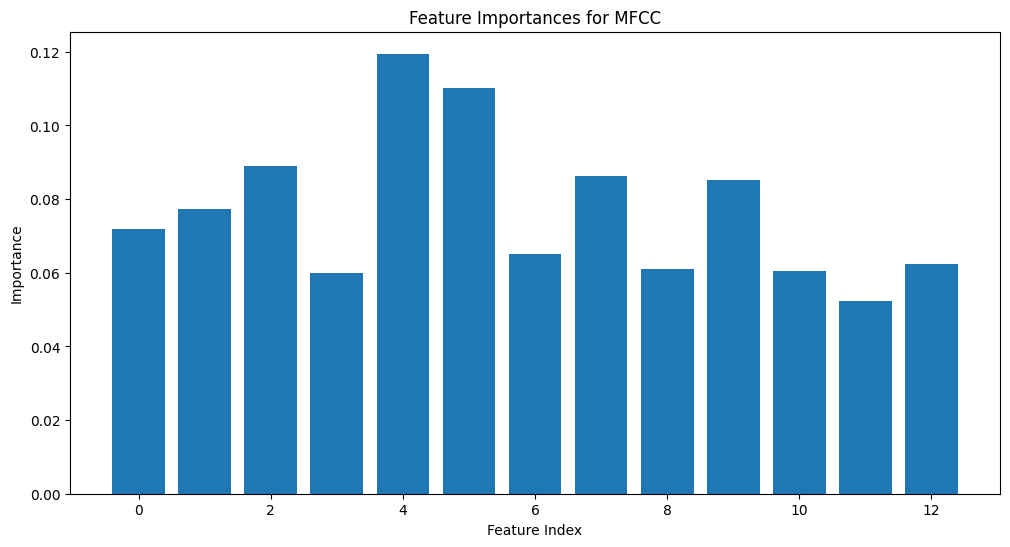

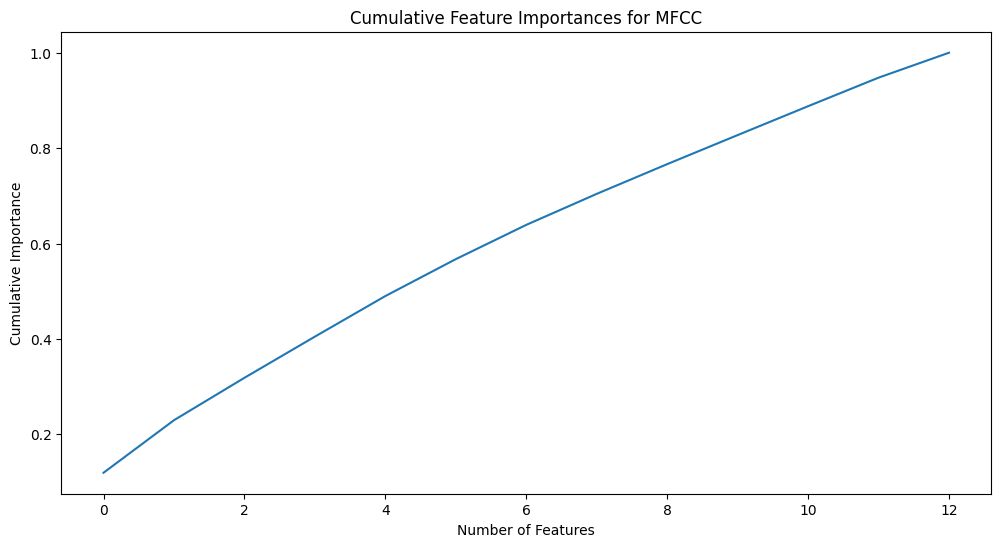

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


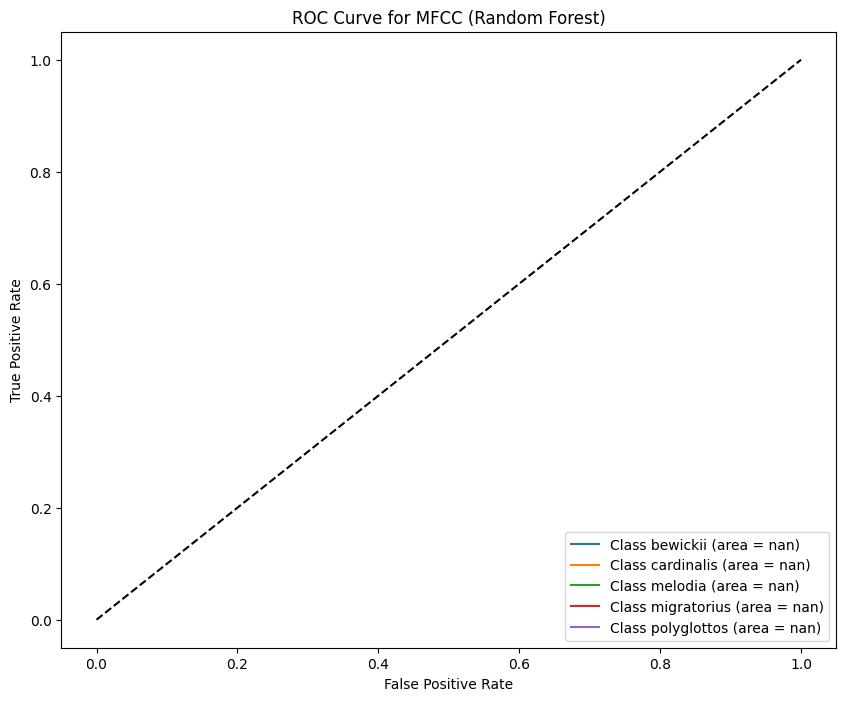

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.83      0.85       193
           1       0.85      0.84      0.84       204
           2       0.82      0.87      0.84       243
           3       0.90      0.95      0.93       207
           4       0.91      0.84      0.88       238

    accuracy                           0.87      1085
   macro avg       0.87      0.87      0.87      1085
weighted avg       0.87      0.87      0.87      1085



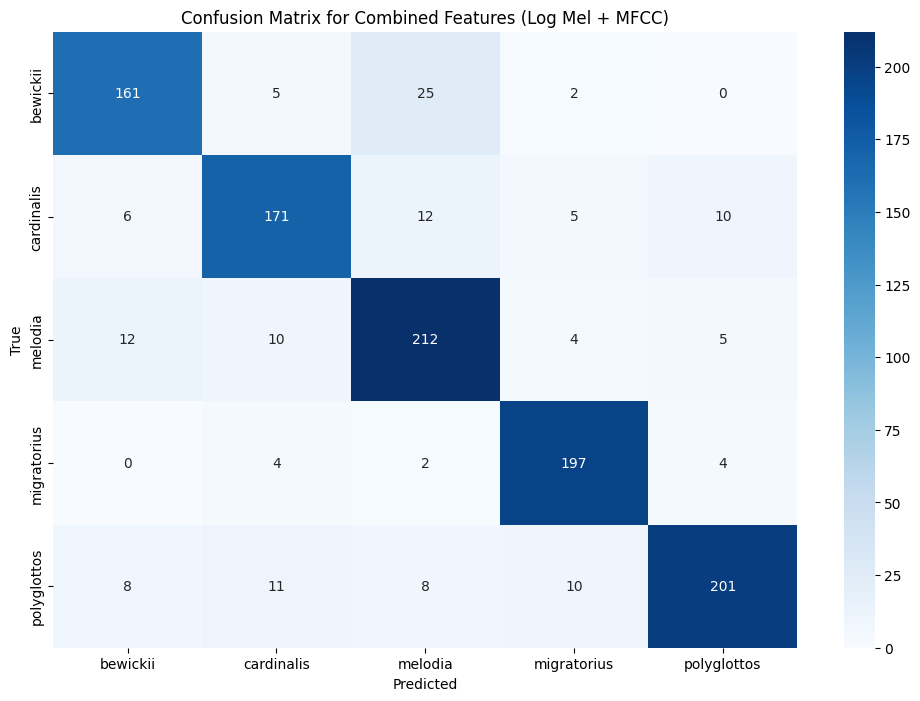

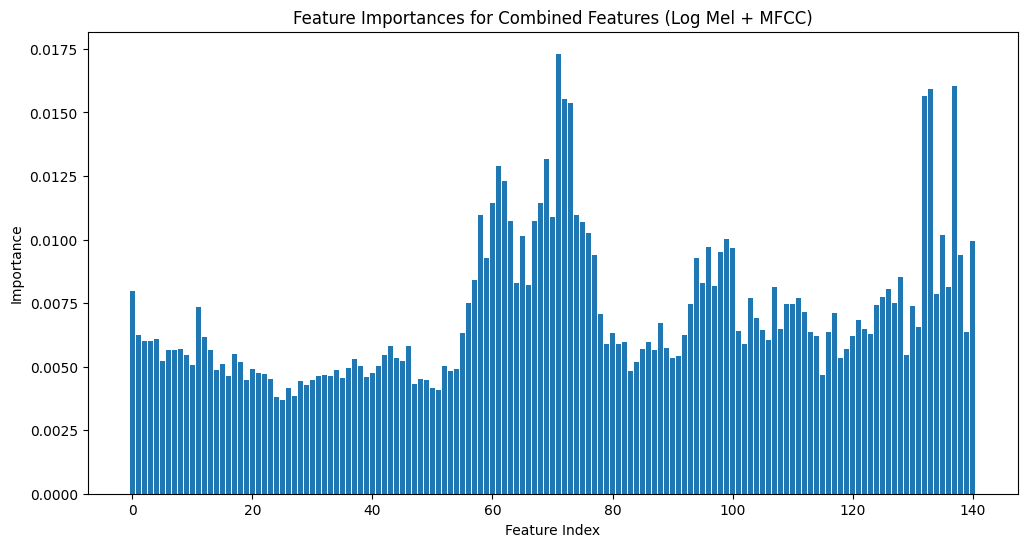

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


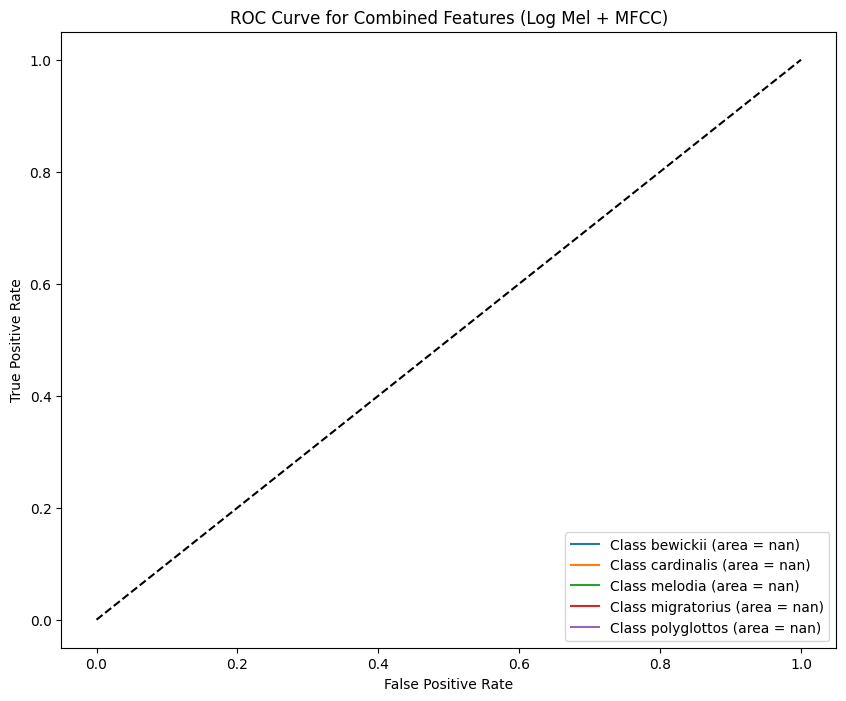

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.83      0.85       193
           1       0.85      0.84      0.84       204
           2       0.82      0.87      0.84       243
           3       0.90      0.95      0.93       207
           4       0.91      0.84      0.88       238

    accuracy                           0.87      1085
   macro avg       0.87      0.87      0.87      1085
weighted avg       0.87      0.87      0.87      1085

Cross-validation Scores: [0.82718894 0.84447005 0.85582468 0.82814302 0.85005767]
Mean Cross-validation Score: 0.841136872206188
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.89      0.82       193
           1       0.91      0.86      0.88       204
           2       0.85      0.84      0.84       243
           3       0.87      0.90      0.89       207
           4       0.93      0.83      0.88       238

    accu

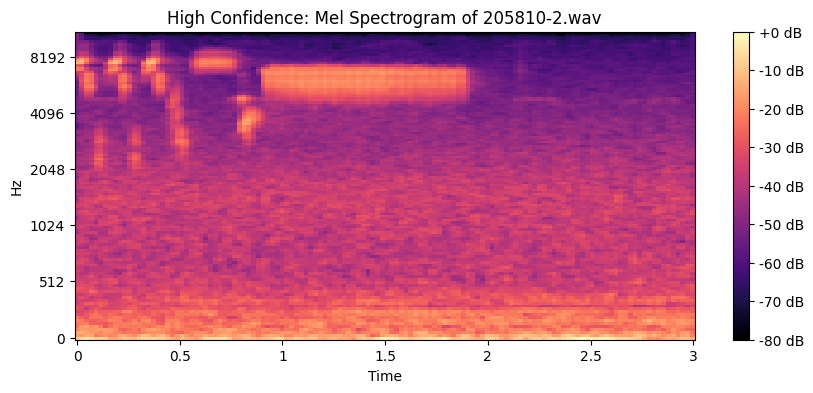

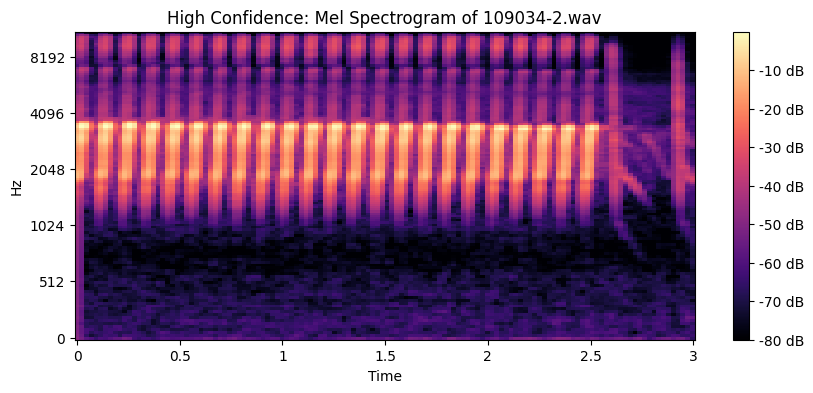

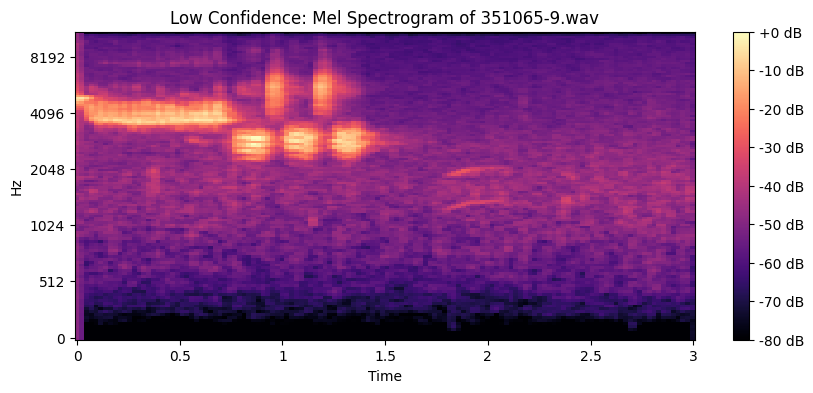

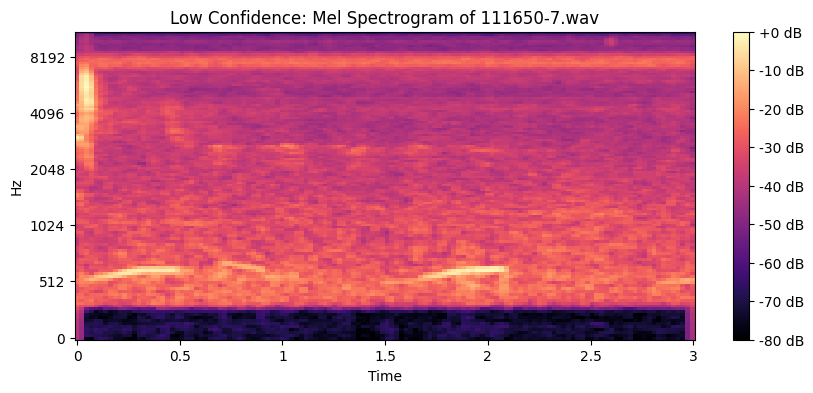

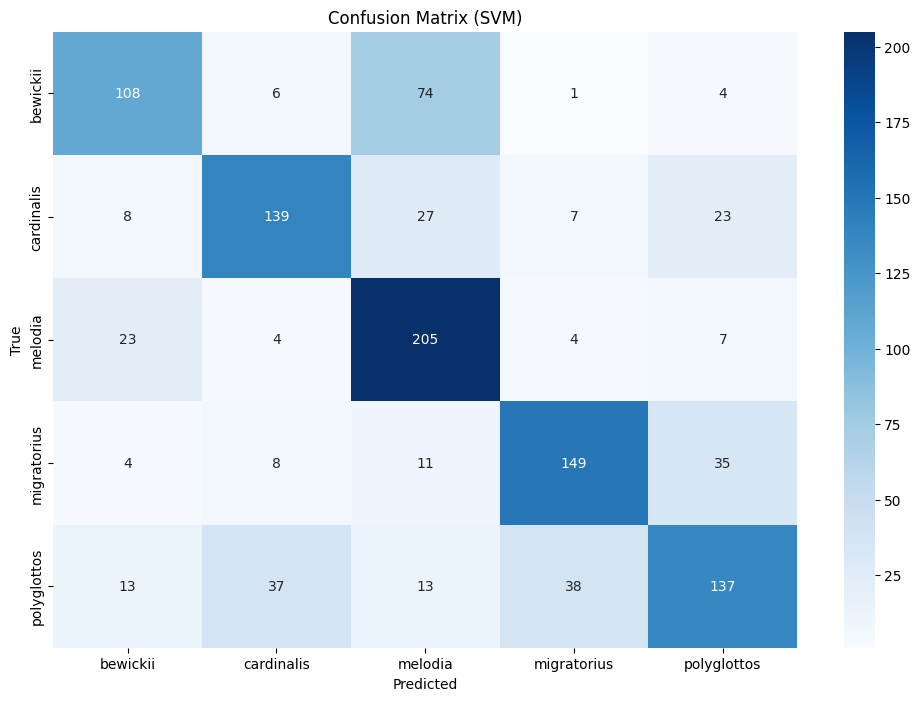

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.56      0.62       193
           1       0.72      0.68      0.70       204
           2       0.62      0.84      0.72       243
           3       0.75      0.72      0.73       207
           4       0.67      0.58      0.62       238

    accuracy                           0.68      1085
   macro avg       0.69      0.68      0.68      1085
weighted avg       0.69      0.68      0.68      1085



'\nshap_svm(X_train_combined, X_test_combined, y_train_combined)\nconfusion_matrices_xgboost(X_train, y_train, X_test, y_test, X_train_mfcc, y_train_mfcc, X_test_mfcc, y_test_mfcc, X_train_combined, y_train_combined, X_test_combined, y_test_combined)\nclassification_report_feature_importance_xgboost(X_train_combined, y_train_combined, X_test_combined, y_test_combined)\nshap_xgboost(X_train_combined, y_train_combined, X_test_combined)\n'

In [17]:
# Example function calls after setup
bar_graph_species(metadata)
mel_spectrogram_all_species(metadata, zip_path)
log_mel_rf_analysis(X_train, y_train, X_test, y_test, classes)
mfcc_rf_analysis(X_train_mfcc, y_train_mfcc, X_test_mfcc, y_test_mfcc, classes)
combined_rf_analysis(X_train_combined, y_train_combined, X_test_combined, y_test_combined, classes)
classification_report_combined_rf(X_train_combined, y_train_combined, X_test_combined, y_test_combined)
knn_classifier = classification_report_knn_mel(X_train, y_train, X_test, y_test)
high_low_confidence_spectrograms_knn(zip_path, metadata, X_test, knn_classifier)
confusion_matrix_classification_report_svm(X_train_combined, y_train_combined, X_test_combined, y_test_combined)
'''
shap_svm(X_train_combined, X_test_combined, y_train_combined)
confusion_matrices_xgboost(X_train, y_train, X_test, y_test, X_train_mfcc, y_train_mfcc, X_test_mfcc, y_test_mfcc, X_train_combined, y_train_combined, X_test_combined, y_test_combined)
classification_report_feature_importance_xgboost(X_train_combined, y_train_combined, X_test_combined, y_test_combined)
shap_xgboost(X_train_combined, y_train_combined, X_test_combined)
'''

In [ ]:
shap_svm(X_train_combined, X_test_combined, y_train_combined)

  0%|          | 0/1085 [00:00<?, ?it/s]

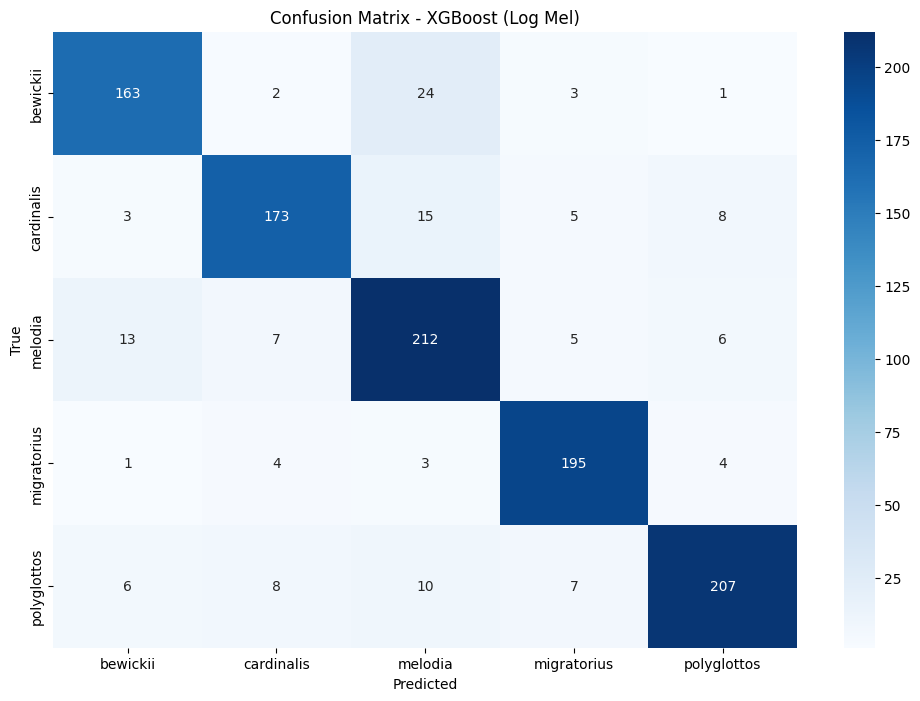

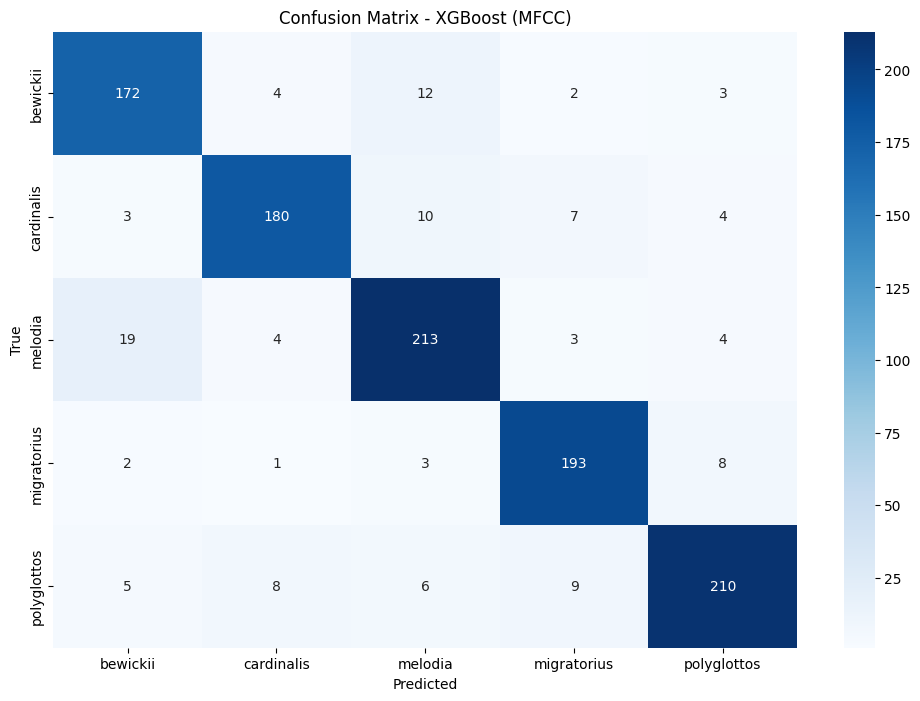

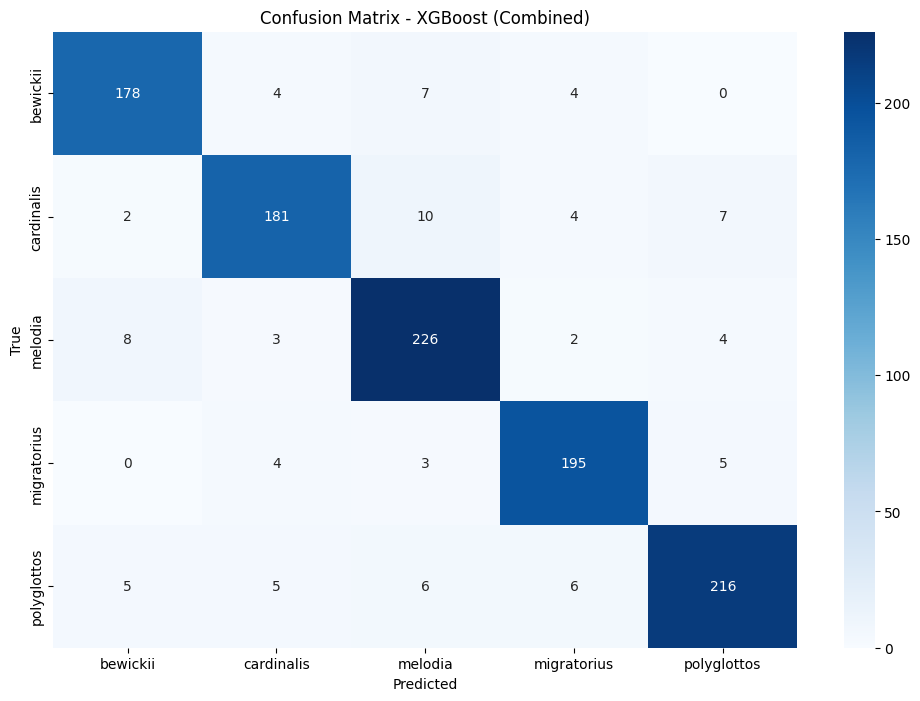

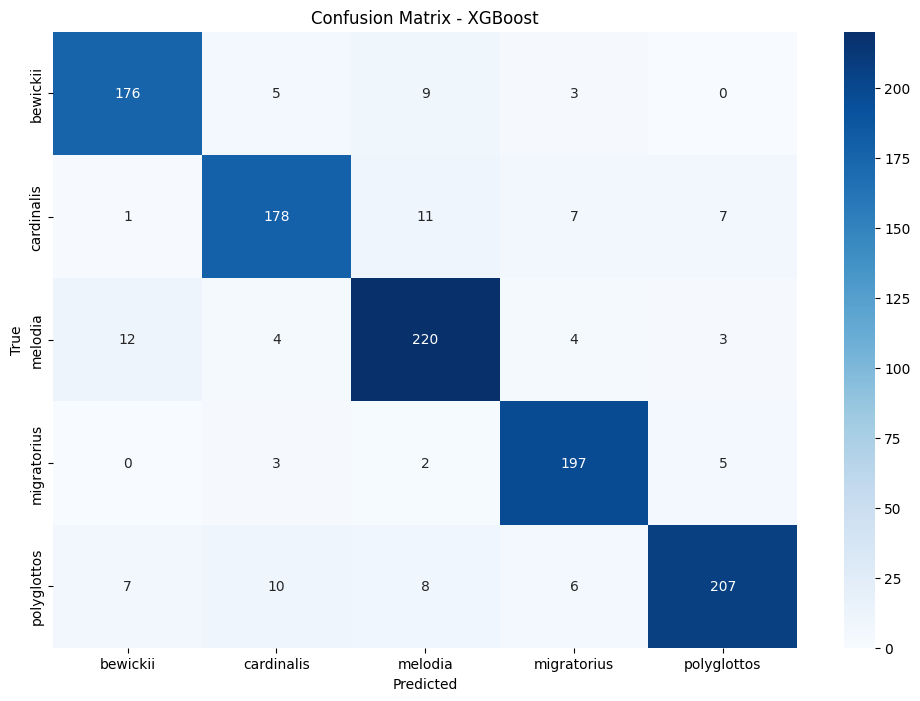

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.90       193
           1       0.89      0.87      0.88       204
           2       0.88      0.91      0.89       243
           3       0.91      0.95      0.93       207
           4       0.93      0.87      0.90       238

    accuracy                           0.90      1085
   macro avg       0.90      0.90      0.90      1085
weighted avg       0.90      0.90      0.90      1085



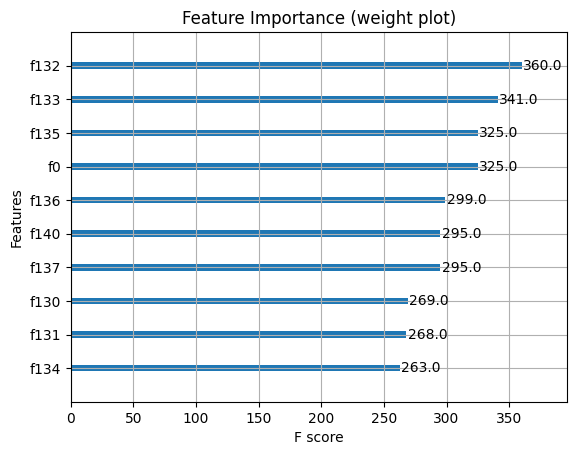

<Figure size 1500x1000 with 0 Axes>

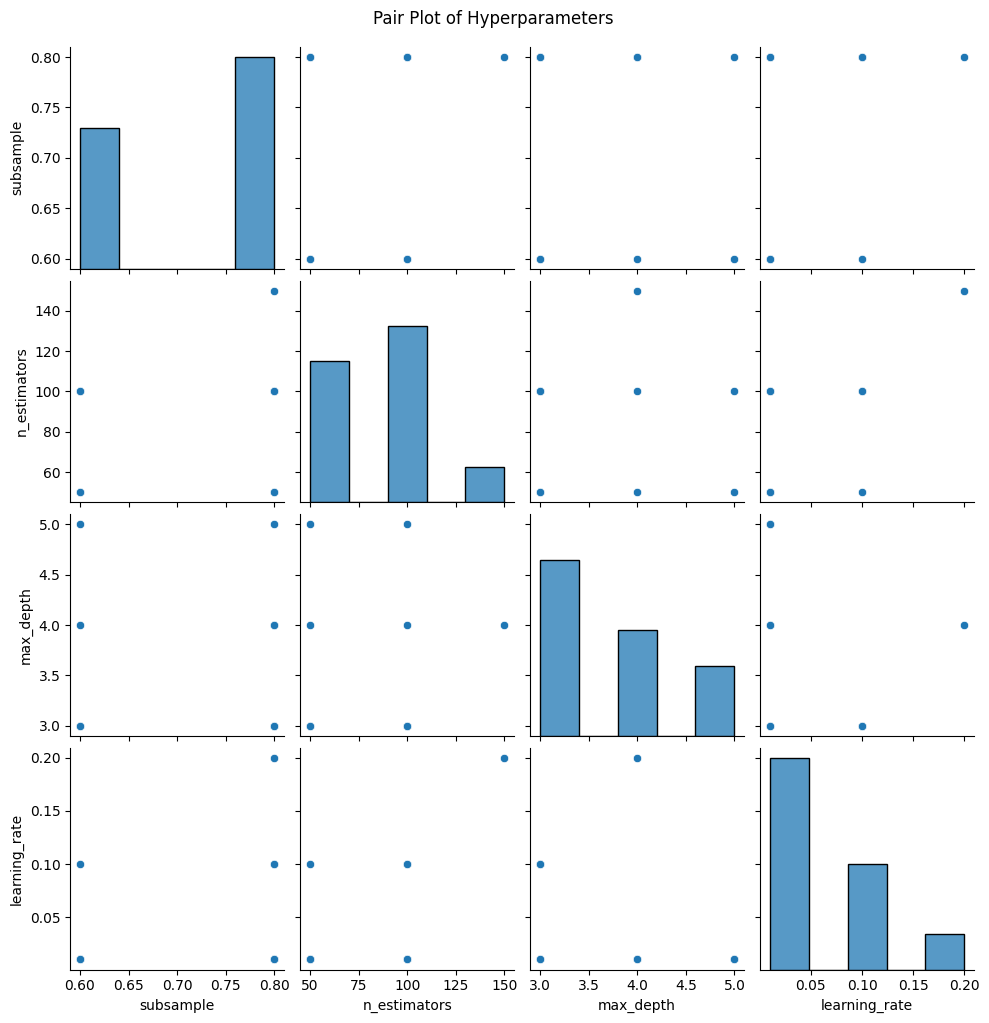

In [18]:
confusion_matrices_xgboost(X_train, y_train, X_test, y_test, X_train_mfcc, y_train_mfcc, X_test_mfcc, y_test_mfcc, X_train_combined, y_train_combined, X_test_combined, y_test_combined)
classification_report_feature_importance_xgboost(X_train_combined, y_train_combined, X_test_combined, y_test_combined)

In [ ]:
shap_xgboost(X_train_combined, y_train_combined, X_test_combined)